# Import necessary libraries

In [28]:
# Imports
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# read excel dataset as csv because system does not allow in any other way 
csv_file_path = '../Data/Telco_customer_churn.xlsx'

try:
    data = pd.read_csv(csv_file_path)
    print("File read successfully as a CSV file.")
    
    # Check the shape of your data
    print("Shape of the data:", data.shape)
    
    # Display the first few rows of the data
    print(data.head(10))
    
except FileNotFoundError:
    print(f"The file at {csv_file_path} was not found. Please check the file path and try again.")
except Exception as e:
    print(f"An unexpected error occurred while reading the file: {e}")

File read successfully as a CSV file.
Shape of the data: (7043, 32)
   Count  Country  State  City  Zip Code  Lat Long   Latitude   Longitude  \
0    1.0        0      0   562   90003.0       327  33.964131 -118.272783   
1    1.0        0      0   562   90005.0       405  34.059281 -118.307420   
2    1.0        0      0   562   90006.0       393  34.048013 -118.293953   
3    1.0        0      0   562   90010.0       410  34.062125 -118.315709   
4    1.0        0      0   562   90015.0       385  34.039224 -118.266293   
5    1.0        0      0   562   90020.0       416  34.066367 -118.309868   
6    1.0        0      0   562   90022.0       367  34.023810 -118.156582   
7    1.0        0      0   562   90024.0       415  34.066303 -118.435479   
8    1.0        0      0   562   90028.0       447  34.099869 -118.326843   
9    1.0        0      0   562   90029.0       440  34.089953 -118.294824   

   Gender  Senior Citizen  ...  Contract  Paperless Billing  Payment Method  \
0    

In [29]:
data.columns

Index(['Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude',
       'Longitude', 'Gender', 'Senior Citizen', 'Partner', 'Dependents',
       'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Label',
       'Churn Value', 'Churn Score', 'CLTV', 'TotalCharges_per_Month'],
      dtype='object')

## Data Cleaning

In [30]:
# Check for missing values
print(data.isnull().sum())


Count                      0
Country                    0
State                      0
City                       0
Zip Code                   0
Lat Long                   0
Latitude                   0
Longitude                  0
Gender                     0
Senior Citizen             0
Partner                    0
Dependents                 0
Tenure Months              0
Phone Service              0
Multiple Lines             0
Internet Service           0
Online Security            0
Online Backup              0
Device Protection          0
Tech Support               0
Streaming TV               0
Streaming Movies           0
Contract                   0
Paperless Billing          0
Payment Method             0
Monthly Charges            0
Total Charges              0
Churn Label                0
Churn Value                0
Churn Score                0
CLTV                       0
TotalCharges_per_Month    11
dtype: int64


In [31]:
# Data types and basic info
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Count                   7043 non-null   float64
 1   Country                 7043 non-null   int64  
 2   State                   7043 non-null   int64  
 3   City                    7043 non-null   int64  
 4   Zip Code                7043 non-null   float64
 5   Lat Long                7043 non-null   int64  
 6   Latitude                7043 non-null   float64
 7   Longitude               7043 non-null   float64
 8   Gender                  7043 non-null   int64  
 9   Senior Citizen          7043 non-null   int64  
 10  Partner                 7043 non-null   int64  
 11  Dependents              7043 non-null   int64  
 12  Tenure Months           7043 non-null   float64
 13  Phone Service           7043 non-null   int64  
 14  Multiple Lines          7043 non-null   

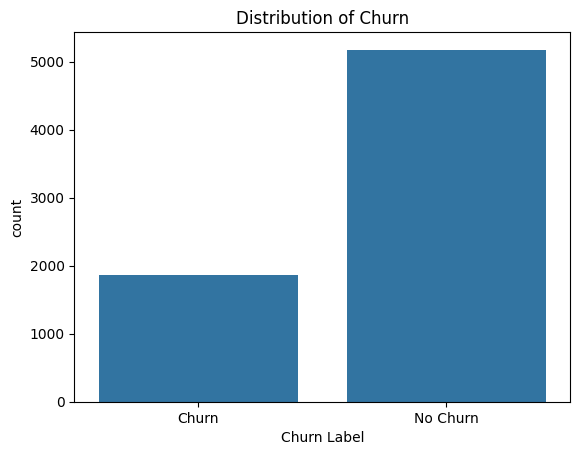

In [32]:
# Convert Churn Label to descriptive labels
data['Churn Label'] = data['Churn Label'].replace({0: 'No Churn', 1: 'Churn'})


# Distribution of the target variable
sns.countplot(x='Churn Label', data=data)
plt.title('Distribution of Churn')
plt.show()

In [33]:
# Summary statistics
print(data.describe())

        Count  Country   State         City      Zip Code     Lat Long  \
count  7043.0   7043.0  7043.0  7043.000000   7043.000000  7043.000000   
mean      1.0      0.0     0.0   593.713616  93521.964646   793.535567   
std       0.0      0.0     0.0   314.990288   1865.794555   480.597035   
min       1.0      0.0     0.0     0.000000  90001.000000     0.000000   
25%       1.0      0.0     0.0   337.000000  92102.000000   376.000000   
50%       1.0      0.0     0.0   601.000000  93552.000000   771.000000   
75%       1.0      0.0     0.0   869.000000  95351.000000  1211.000000   
max       1.0      0.0     0.0  1128.000000  96161.000000  1651.000000   

          Latitude    Longitude       Gender  Senior Citizen  ...  \
count  7043.000000  7043.000000  7043.000000     7043.000000  ...   
mean     36.282441  -119.798880     0.504756        0.162147  ...   
std       2.455723     2.157889     0.500013        0.368612  ...   
min      32.555828  -124.301372     0.000000        0.000

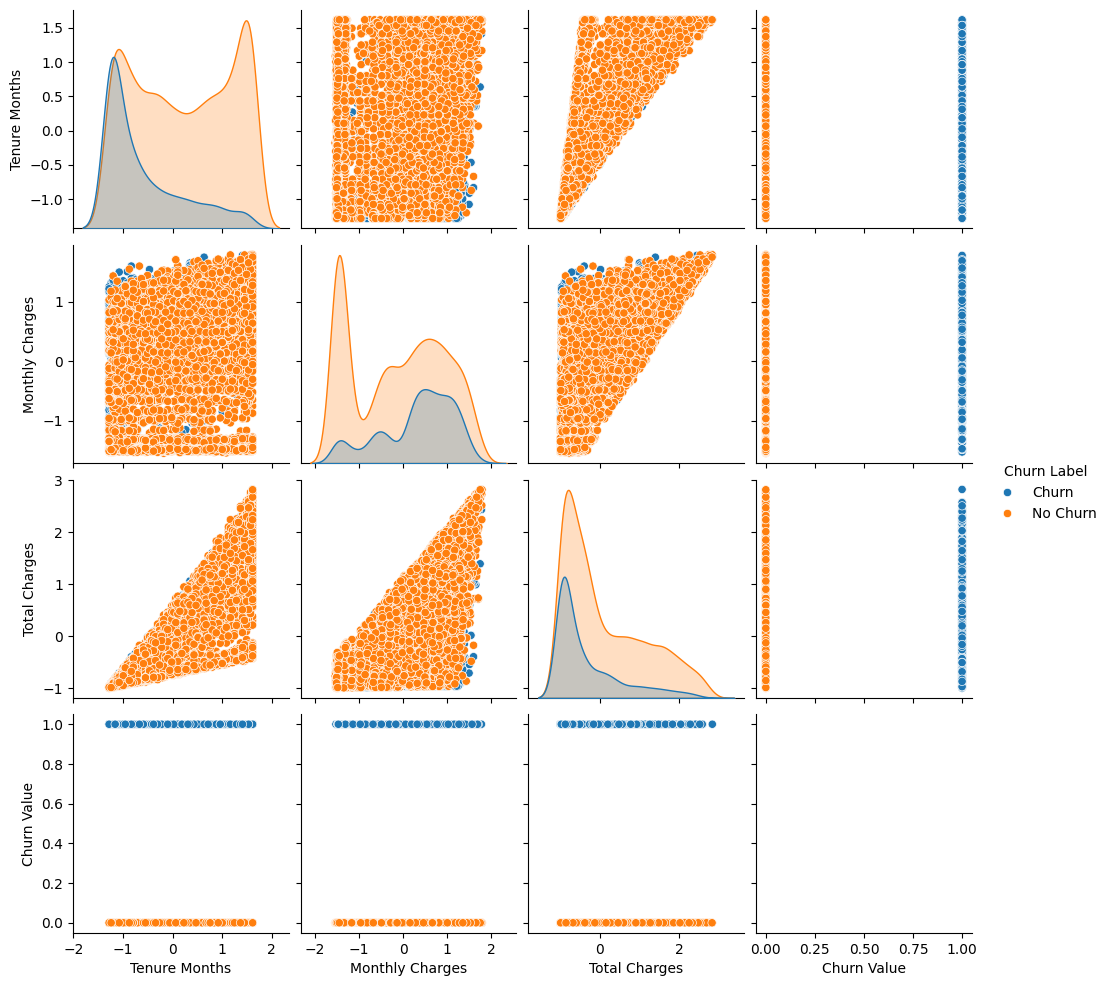

In [34]:
# Simplify the pairplot to focus on key features
key_features = ['Tenure Months', 'Monthly Charges', 'Total Charges', 'Churn Value']
sns.pairplot(data[key_features + ['Churn Label']], hue='Churn Label', diag_kind='kde')
plt.show()

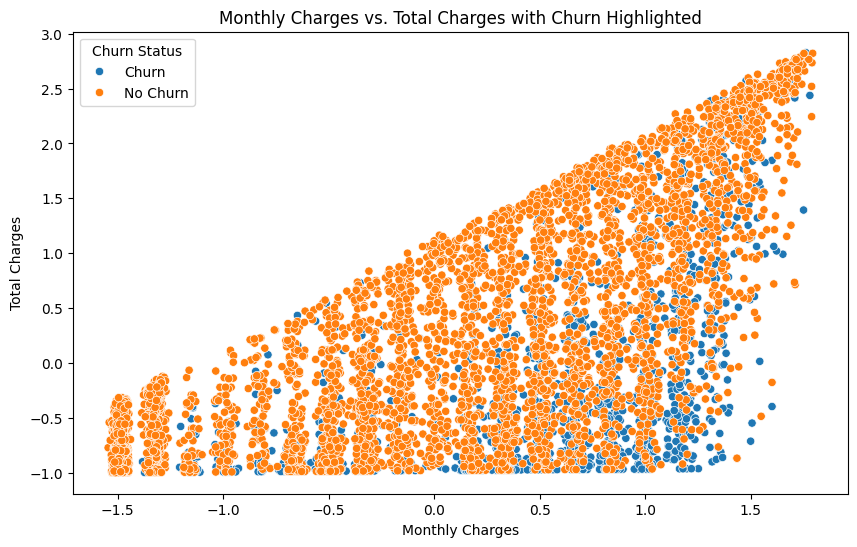

In [35]:
# Data Cleaning and Preparation
data['Total Charges'] = pd.to_numeric(data['Total Charges'], errors='coerce')
data['Total Charges'] = data['Total Charges'].fillna(data['Total Charges'].median())

# Normalize numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_features = ['Monthly Charges', 'Total Charges']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Convert Churn Label to descriptive labels
data['Churn Label'] = data['Churn Label'].replace({0: 'No Churn', 1: 'Churn'})

# Correct the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Monthly Charges', y='Total Charges', hue='Churn Label', data=data)
plt.title('Monthly Charges vs. Total Charges with Churn Highlighted')
plt.xlabel('Monthly Charges')
plt.ylabel('Total Charges')
plt.legend(title='Churn Status', loc='upper left')
plt.show()


## Plot description for Tenure Months Distribution for Churn and Non-Churn Customers


This plot shows the distribution of the tenure (in months) of customers who churned (left the service) and those who did not.
 It helps to visualize the relationship between how long a customer has been with the service and their likelihood of leaving.

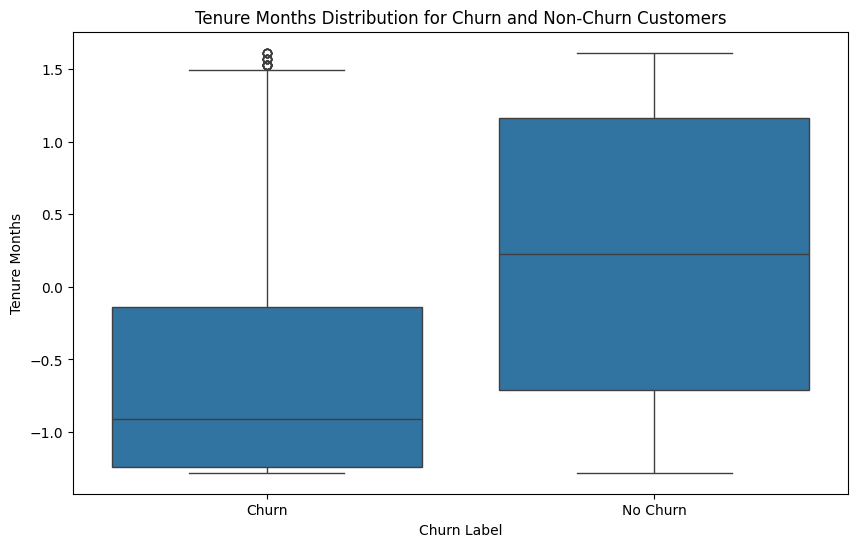

In [36]:
# Plot to highlight relationship between Tenure and Churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn Label', y='Tenure Months', data=data)
plt.title('Tenure Months Distribution for Churn and Non-Churn Customers')
plt.xlabel('Churn Label')
plt.ylabel('Tenure Months')
plt.annotate('Low Tenure, High Churn', xy=(1, 10), xytext=(1.5, 20),
             arrowprops=dict(facecolor='blue', shrink=0.05))
plt.show()
# Convert Churn Label to descriptive labels
data['Churn Label'] = data['Churn Label'].replace({0: 'No Churn', 1: 'Churn'})

### Plot describtion for relationship between Tenure and Churn



This plot shows how long customers have been with the company (tenure months) and whether they have canceled (churn label).

 The boxes show the distribution of the length of stay for both groups: Customers who have churned (1), and customers who have not churned (0). 
 
 The note "Low tenure, high churn" indicates that customers who have been with the company for a shorter period of time are more likely to quit.


## Plot description for "Contract Type vs. Churn"
This plot compares the contract types (Month-to-month, One year, Two year) and their respective churn rates. It helps to identify which contract types are more prone to customer churn.

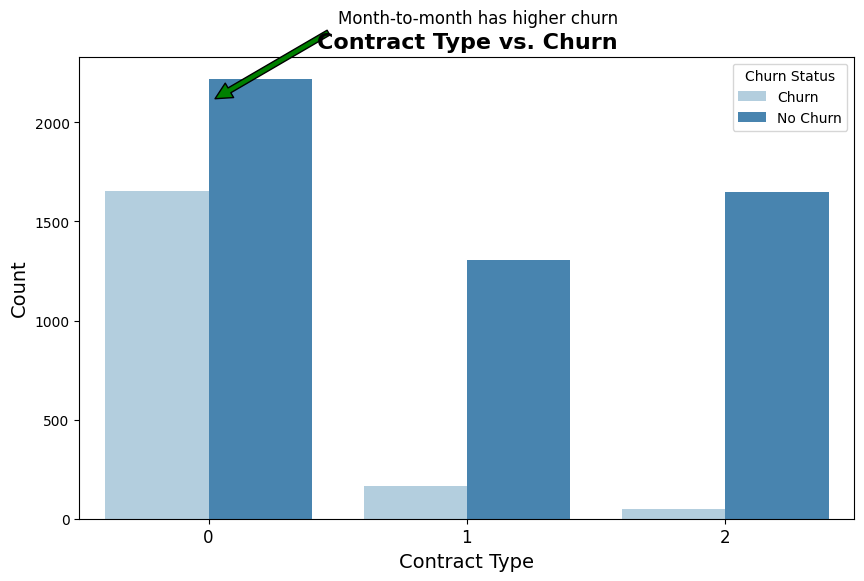

In [37]:
# Convert Churn Label to descriptive labels
data['Churn Label'] = data['Churn Label'].replace({0: 'No Churn', 1: 'Churn'})

# Plot to highlight impact of Contract Type on Churn using blue tones
plt.figure(figsize=(10, 6))
sns.countplot(x='Contract', hue='Churn Label', data=data, palette='Blues')
plt.title('Contract Type vs. Churn', fontsize=16, weight='bold')
plt.xlabel('Contract Type', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Adjust annotation to match the reference image
plt.annotate('Month-to-month has higher churn', xy=(0, 2100), xytext=(0.5, 2500),
             arrowprops=dict(facecolor='green', shrink=0.05), fontsize=12)

# Adjust the legend to match the reference image
plt.legend(title='Churn Status', loc='upper right')

# Ensure that the x-axis labels are correctly displayed
plt.xticks(rotation=0, fontsize=12)

# Display the plot
plt.show()

## Plot description for Monthly Charges vs. Total Charges with Churn Highlighted

This scatter plot shows the relationship between monthly charges and total charges, with churn status highlighted.

 It helps to see if there is a pattern in the charges that correlates with customer churn.

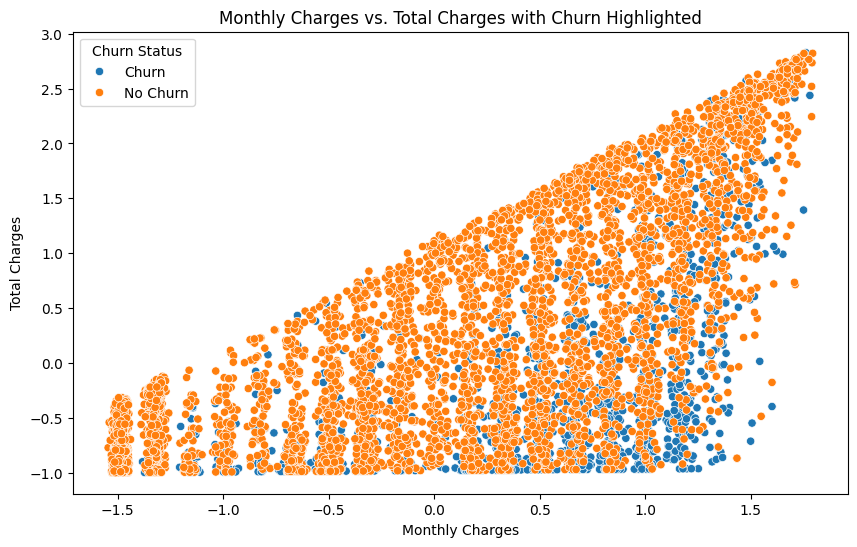

In [38]:
# Normalize numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_features = ['Monthly Charges', 'Total Charges']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Convert Churn Label to descriptive labels
data['Churn Label'] = data['Churn Label'].replace({0: 'No Churn', 1: 'Churn'})

# Correct the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Monthly Charges', y='Total Charges', hue='Churn Label', data=data)
plt.title('Monthly Charges vs. Total Charges with Churn Highlighted')
plt.xlabel('Monthly Charges')
plt.ylabel('Total Charges')
plt.legend(title='Churn Status', loc='upper left')
plt.show()

###  Plot to highlight impact of Contract Type on Churn

This plot shows how the type of contract influences the churn rate. 
Customers with month-to-month contracts have a higher churn rate compared to customers with longer contract terms (one-year or two-year contracts).

/var/folders/f6/2h1ph12j6r9c8gpllh_52j940000gn/T/ipykernel_26324/650805444.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn Label', y='Monthly Charges', data=data, palette="Set2")


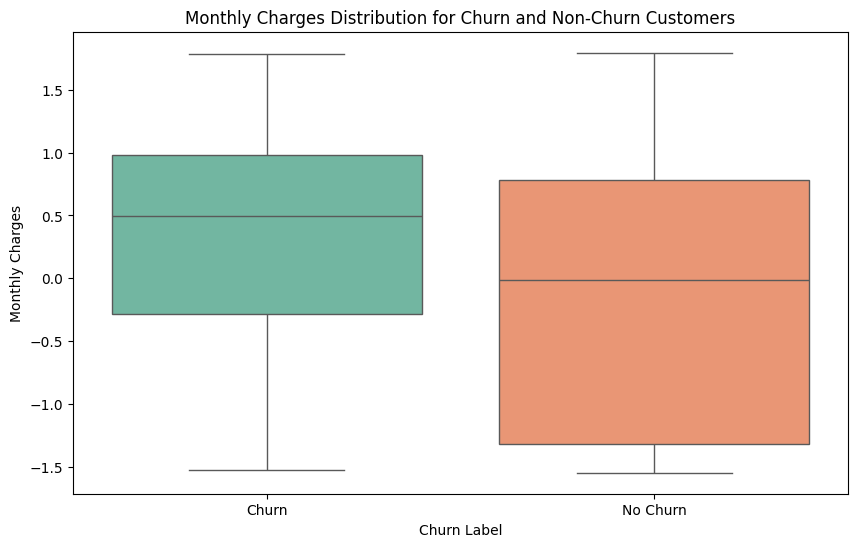

In [39]:
# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['Tenure Months', 'Monthly Charges', 'Total Charges', 'TotalCharges_per_Month']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Convert Churn Label to descriptive labels
data['Churn Label'] = data['Churn Label'].replace({0: 'No Churn', 1: 'Churn'})

# Plot 1: Monthly Charges vs. Churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn Label', y='Monthly Charges', data=data, palette="Set2")
plt.title('Monthly Charges Distribution for Churn and Non-Churn Customers')
plt.xlabel('Churn Label')
plt.ylabel('Monthly Charges')
plt.show()

## Plot 1 Conclusion:

***You can see that customers who canceled the service had slightly higher monthly fees on average.***

/var/folders/f6/2h1ph12j6r9c8gpllh_52j940000gn/T/ipykernel_26324/943518494.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn Label', y='Total Charges', data=data, palette="Set1")


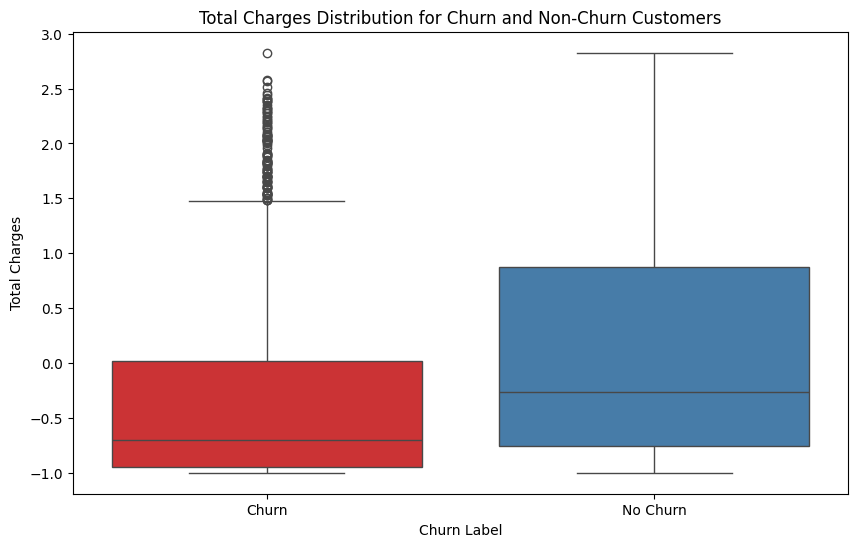

In [40]:
# Plot 2: Total Charges vs. Churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn Label', y='Total Charges', data=data, palette="Set1")
plt.title('Total Charges Distribution for Churn and Non-Churn Customers')
plt.xlabel('Churn Label')
plt.ylabel('Total Charges')
plt.show()

## Plot 2 Conclusion:

***Customers who canceled the service paid less overall because they were often customers for a shorter period of time.***

/var/folders/f6/2h1ph12j6r9c8gpllh_52j940000gn/T/ipykernel_26324/1597505960.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn Label', y='Tenure Months', data=data, palette="Set3")


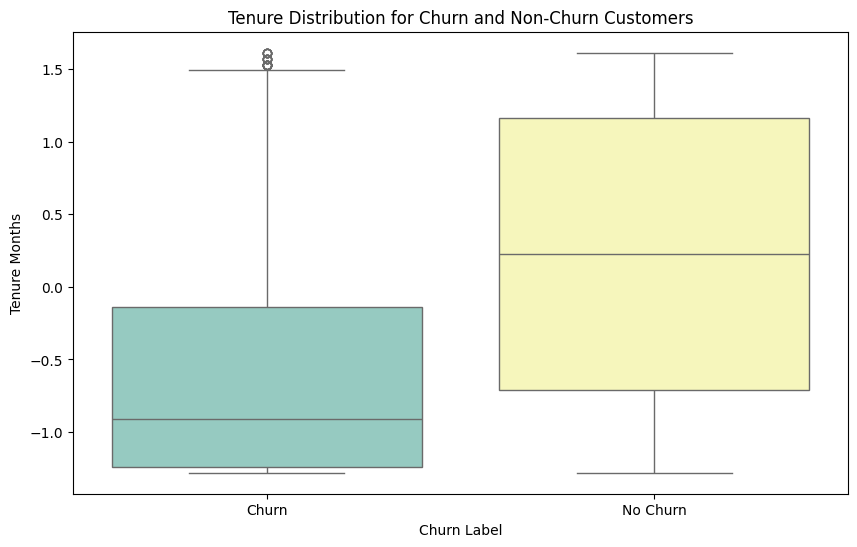

In [41]:
# Plot 3: Tenure vs. Churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn Label', y='Tenure Months', data=data, palette="Set3")
plt.title('Tenure Distribution for Churn and Non-Churn Customers')
plt.xlabel('Churn Label')
plt.ylabel('Tenure Months')
plt.show()


## Plot 3 Conclusion:

***Customers who canceled the service often used the service for a shorter period of time than customers who stayed.***

# Data Cleaning and Feature Engineering

In [42]:
# Data Cleaning and Preparation
data['Total Charges'] = data['Total Charges'].replace(" ", np.nan)
data['Total Charges'] = pd.to_numeric(data['Total Charges'], errors='coerce')
data['Total Charges'] = data['Total Charges'].fillna(data['Total Charges'].median())

In [43]:
# Replace zeroes with NaN to prevent division by zero
data['Tenure Months'].replace(0, np.nan, inplace=True)
data['TotalCharges_per_Month'] = data['Total Charges'] / data['Tenure Months']

/var/folders/f6/2h1ph12j6r9c8gpllh_52j940000gn/T/ipykernel_26324/3435525171.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Tenure Months'].replace(0, np.nan, inplace=True)


In [44]:
# Replace infinite values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [45]:
# Impute remaining missing values
numerical_columns = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = data.select_dtypes(include=[object]).columns.tolist()
imputer_num = SimpleImputer(strategy='median')
data[numerical_columns] = imputer_num.fit_transform(data[numerical_columns])

In [46]:
# Encoding categorical variables
le = LabelEncoder()
for column in categorical_columns:
    if column not in ['CustomerID', 'Churn Reason']:
        data[column] = le.fit_transform(data[column])

In [47]:
# Feature engineering
# Prevent division by zero by replacing zeroes with NaN in 'Tenure Months'
data['Tenure Months'].replace(0, np.nan, inplace=True)
data['TotalCharges_per_Month'] = data['Total Charges'] / data['Tenure Months']

/var/folders/f6/2h1ph12j6r9c8gpllh_52j940000gn/T/ipykernel_26324/4253628537.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Tenure Months'].replace(0, np.nan, inplace=True)


In [48]:
# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['Tenure Months', 'Monthly Charges', 'Total Charges', 'TotalCharges_per_Month']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Ensure no NaN values remain in the data
print(data.isnull().sum())

Count                     0
Country                   0
State                     0
City                      0
Zip Code                  0
Lat Long                  0
Latitude                  0
Longitude                 0
Gender                    0
Senior Citizen            0
Partner                   0
Dependents                0
Tenure Months             0
Phone Service             0
Multiple Lines            0
Internet Service          0
Online Security           0
Online Backup             0
Device Protection         0
Tech Support              0
Streaming TV              0
Streaming Movies          0
Contract                  0
Paperless Billing         0
Payment Method            0
Monthly Charges           0
Total Charges             0
Churn Label               0
Churn Value               0
Churn Score               0
CLTV                      0
TotalCharges_per_Month    0
dtype: int64


##  Preparing Data for Modeling

In [49]:
# Define features and target variable
X = data.drop(['Churn Label', 'Churn Value'], axis=1)
y = data['Churn Value']

#Check for any remaining NaN values in X and y
print("NaN values in X: ", X.isnull().sum().sum())
print("NaN values in y: ", y.isnull().sum())

NaN values in X:  0
NaN values in y:  0


In [50]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values in X_train and X_test
X_train = imputer_num.fit_transform(X_train)
X_test = imputer_num.transform(X_test)

# Ensure no NaN values remain in the imputed data
print("NaN values in X_train after imputation: ", np.isnan(X_train).sum())
print("NaN values in X_test after imputation: ", np.isnan(X_test).sum())

NaN values in X_train after imputation:  0
NaN values in X_test after imputation:  0


##  Model Development and Initial Tuning

In [51]:
# Initial model with RandomForest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
print("Random Forest Model")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Random Forest Model
Accuracy: 0.9311568488289567
[[976  33]
 [ 64 336]]
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      1009
         1.0       0.91      0.84      0.87       400

    accuracy                           0.93      1409
   macro avg       0.92      0.90      0.91      1409
weighted avg       0.93      0.93      0.93      1409



## Advanced Modeling and Hyperparameter Tuning

In [52]:
# Gradient Boosting Model
gb_model = GradientBoostingClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 4, 5]
}

In [53]:
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

In [54]:
# Ensure the input data does not contain NaN values before fitting
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   2.5s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   2.5s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   2.5s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   6.2s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=   4.7s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   7.7s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   7.8s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=   6.3s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=   6.3s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   7.2s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=200; total time=  12.4s
[CV] END ...learning_rate=0.1, max_depth=4, n_es

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200]},
             verbose=2)

# The output you are seeing comes from a GridSearchCV run, which is used to find the best hyperparameters for a model. Let's break down the different parts of this output:

Fitting 3 folds for each of 12 candidates, totalling 36 fits:

***GridSearchCV is performing cross-validation by splitting the data into 3 folds.***
For each set of hyperparameters, the model is trained and evaluated three times (once for each fold).
There are 12 combinations of hyperparameters (n_estimators: 2 values, learning_rate: 2 values, max_depth: 3 values). Therefore, a total of 36 trainings and evaluations are performed (12 combinations * 3 folds).
[CV] END ...:

***These lines show*** the results of individual training runs with specific hyperparameter combinations.
For example, [CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time= 3.4s means that a model with learning_rate=0.1, max_depth=3, and n_estimators=100 was trained, and the training took 3.4 seconds.
GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42), n_jobs=-1, param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [3, 4, 5], 'n_estimators': [100, 200]}, verbose=2):

***This is a summary of the GridSearchCV settings.***
cv=3: Cross-validation with 3 folds.
estimator=GradientBoostingClassifier(random_state=42): The model being optimized is a Gradient Boosting Classifier.
n_jobs=-1: Use all available CPUs for training.
param_grid: The hyperparameter combinations being tried.
verbose=2: Detailed output during training.
best_estimator_: GradientBoostingClassifier:

GridSearchCV has found the best hyperparameters, and the best model is a GradientBoostingClassifier.

***Here is an example of how you can further use the results from the GridSearchCV:***

In [55]:
# Retrieve the best hyperparameters and the best model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Model:", best_model)
print("Best Parameters:", best_params)

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model
print("Best Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Best Model: GradientBoostingClassifier(random_state=42)
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Model Performance
Accuracy: 0.9283179559971612
[[962  47]
 [ 54 346]]
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      1009
         1.0       0.88      0.86      0.87       400

    accuracy                           0.93      1409
   macro avg       0.91      0.91      0.91      1409
weighted avg       0.93      0.93      0.93      1409

